<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perfil de emissões do matopiba

In [91]:
#analisis
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import bartlett

import matplotlib.gridspec as gridspec

#visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pandas.plotting import radviz

## Data Base 

In [4]:
! git clone https://github.com/lucas-fpaiva/matopiba_emissions.git
df = pd.read_csv('/content/matopiba_emissions/data/data.csv',
              error_bad_lines=False, encoding='latin-1',sep=';')#

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(328, 9)

### Data cleaning

In [ ]:
df['emi_energy_2018']=pd.to_numeric(df['emi_energy_2018'],errors='coerce')
df.dropna(inplace=True)
df.columns

data=df[['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 
       'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018', 
        'pib_2018']]

data['population'] = 1000*df['pib_2018']/df['pib_percapta_2018']
data['population']= data['population'].astype(int)
df.dropna(inplace=True)
data.shape

### Feature engineering


In [11]:
def features_func(data_l):
    
    emi_2018 = ['emi_2018', 'emi_agri_2018', 'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018']
    
    
    j=0
    for i in emi_2018[1:]:
        data_l[features[j]] = data_l[i]/data_l[emi_2018[0]]
        j+=1

    return data_l

In [79]:
features=["Agriculture and Livestock","LUC","Energy","Waste"]
features_group=["Agriculture and Livestock","LUC","Energy","Waste","group"]
data_proces= features_func(data)
data_proces.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,States,Municipalities,emi_2018,emi_agri_2018,emi_luc_2018,emi_energy_2018,emi_waste_2018,pib_2018,population,Agriculture and Livestock,LUC,Energy,Waste,group,group_name
0,TO,AbreulÃ¢ndia,415469.12,127828.13,286357,530.51,753.48,52402.19,2564,0.307672,0.689238,0.001277,0.001814,1,G1
1,MA,AÃ§ailÃ¢ndia,2012738.16,701929.89,1033654,221796.36,55357.90,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,1,G1
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468,0.094138,0.758761,0.129712,0.017389,5,G5
3,MA,Ãgua Doce do MaranhÃ£o,28598.69,6986.73,15176,3941.72,2494.25,86186.06,12488,0.244302,0.530654,0.137829,0.087216,1,G1
4,TO,AguiarnÃ³polis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571,0.177852,0.271308,0.534922,0.015919,2,G2


## Identified groups

In [54]:
def number_of_clusters(wcss,interval):
    x1, y1 = interval[0], wcss[0]
    x2, y2 = interval[1], wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


def silhouette_plot_(X,range_n,lim):
  nome = list(X.columns)

  kmeans_per_k = [KMeans(k,init = "k-means++", n_init=50, random_state=0).fit(X)
                for k in range(1, lim)]
  inertias = [model.inertia_ for model in kmeans_per_k]

  k_opt = number_of_clusters(inertias,[1,lim])
  print(k_opt)
  fig = plt.figure(figsize = (15, 10), dpi = 300)
  gs = gridspec.GridSpec(11, 3)
  ax = fig.add_subplot(gs[0:4, :])
  ax.plot(range(2,lim+1), inertias, "bo-")
  ks = [k_opt-1,k_opt,k_opt+1]

  # print("k ótimo: ", k_opt)
  ax.plot(ks,inertias[k_opt-3:k_opt],"ro-",linewidth=2, markersize=12)

  ax.set_ylabel("WCSS", fontsize=fontsize)
  ax.set_xlabel("Groups \n", fontsize=fontsize)
  ax.grid(True)
  ax.annotate('Elbow',
             xy=(k_opt, inertias[k_opt]+0.5),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

  j=0
   
  ax.text(-0.15/3, 1.1, 'a', transform=ax.transAxes, 
            size=22, weight='bold')
    
    
  for n_clusters in range_n:
    
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, init = "k-means++", n_init=50, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters==k_opt:
      global model_top
      global labels 
      labels = cluster_labels
      model_top = clusterer

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = fig.add_subplot(gs[6:11, j])
    ax.grid(True)
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
    
    
    for i in range(n_clusters-1,-1,-1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them      
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
    
  #   for i in range(1,k+1):
  # color.append(cm.nipy_spectral(float(i-1)*1.1 /k))

      color = cm.nipy_spectral(float(i)*1.1 / n_clusters)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=1)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples
      # print(i,len(ith_cluster_silhouette_values))
    
      ax.set_title("k = "+str(n_clusters),fontsize=fontsize)
    if j==1:
      ax.set_xlabel("Silhouette score", fontsize=fontsize)
    if j==0:
        ax.set_ylabel("Groups \n", fontsize=fontsize)
        ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
            size=22, weight='bold')
    j+=1
    # The vertical line for average silhouette score of all the values
    ax.set_xlim([-0.2, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  plt.savefig("/content/matopiba_emissions/output/figure1.pdf", format="pdf", dpi=1000)
  plt.show()
  



6
For n_clusters = 5 The average silhouette_score is : 0.42146118408488387
For n_clusters = 6 The average silhouette_score is : 0.42444966752841917
For n_clusters = 7 The average silhouette_score is : 0.40231761635176794


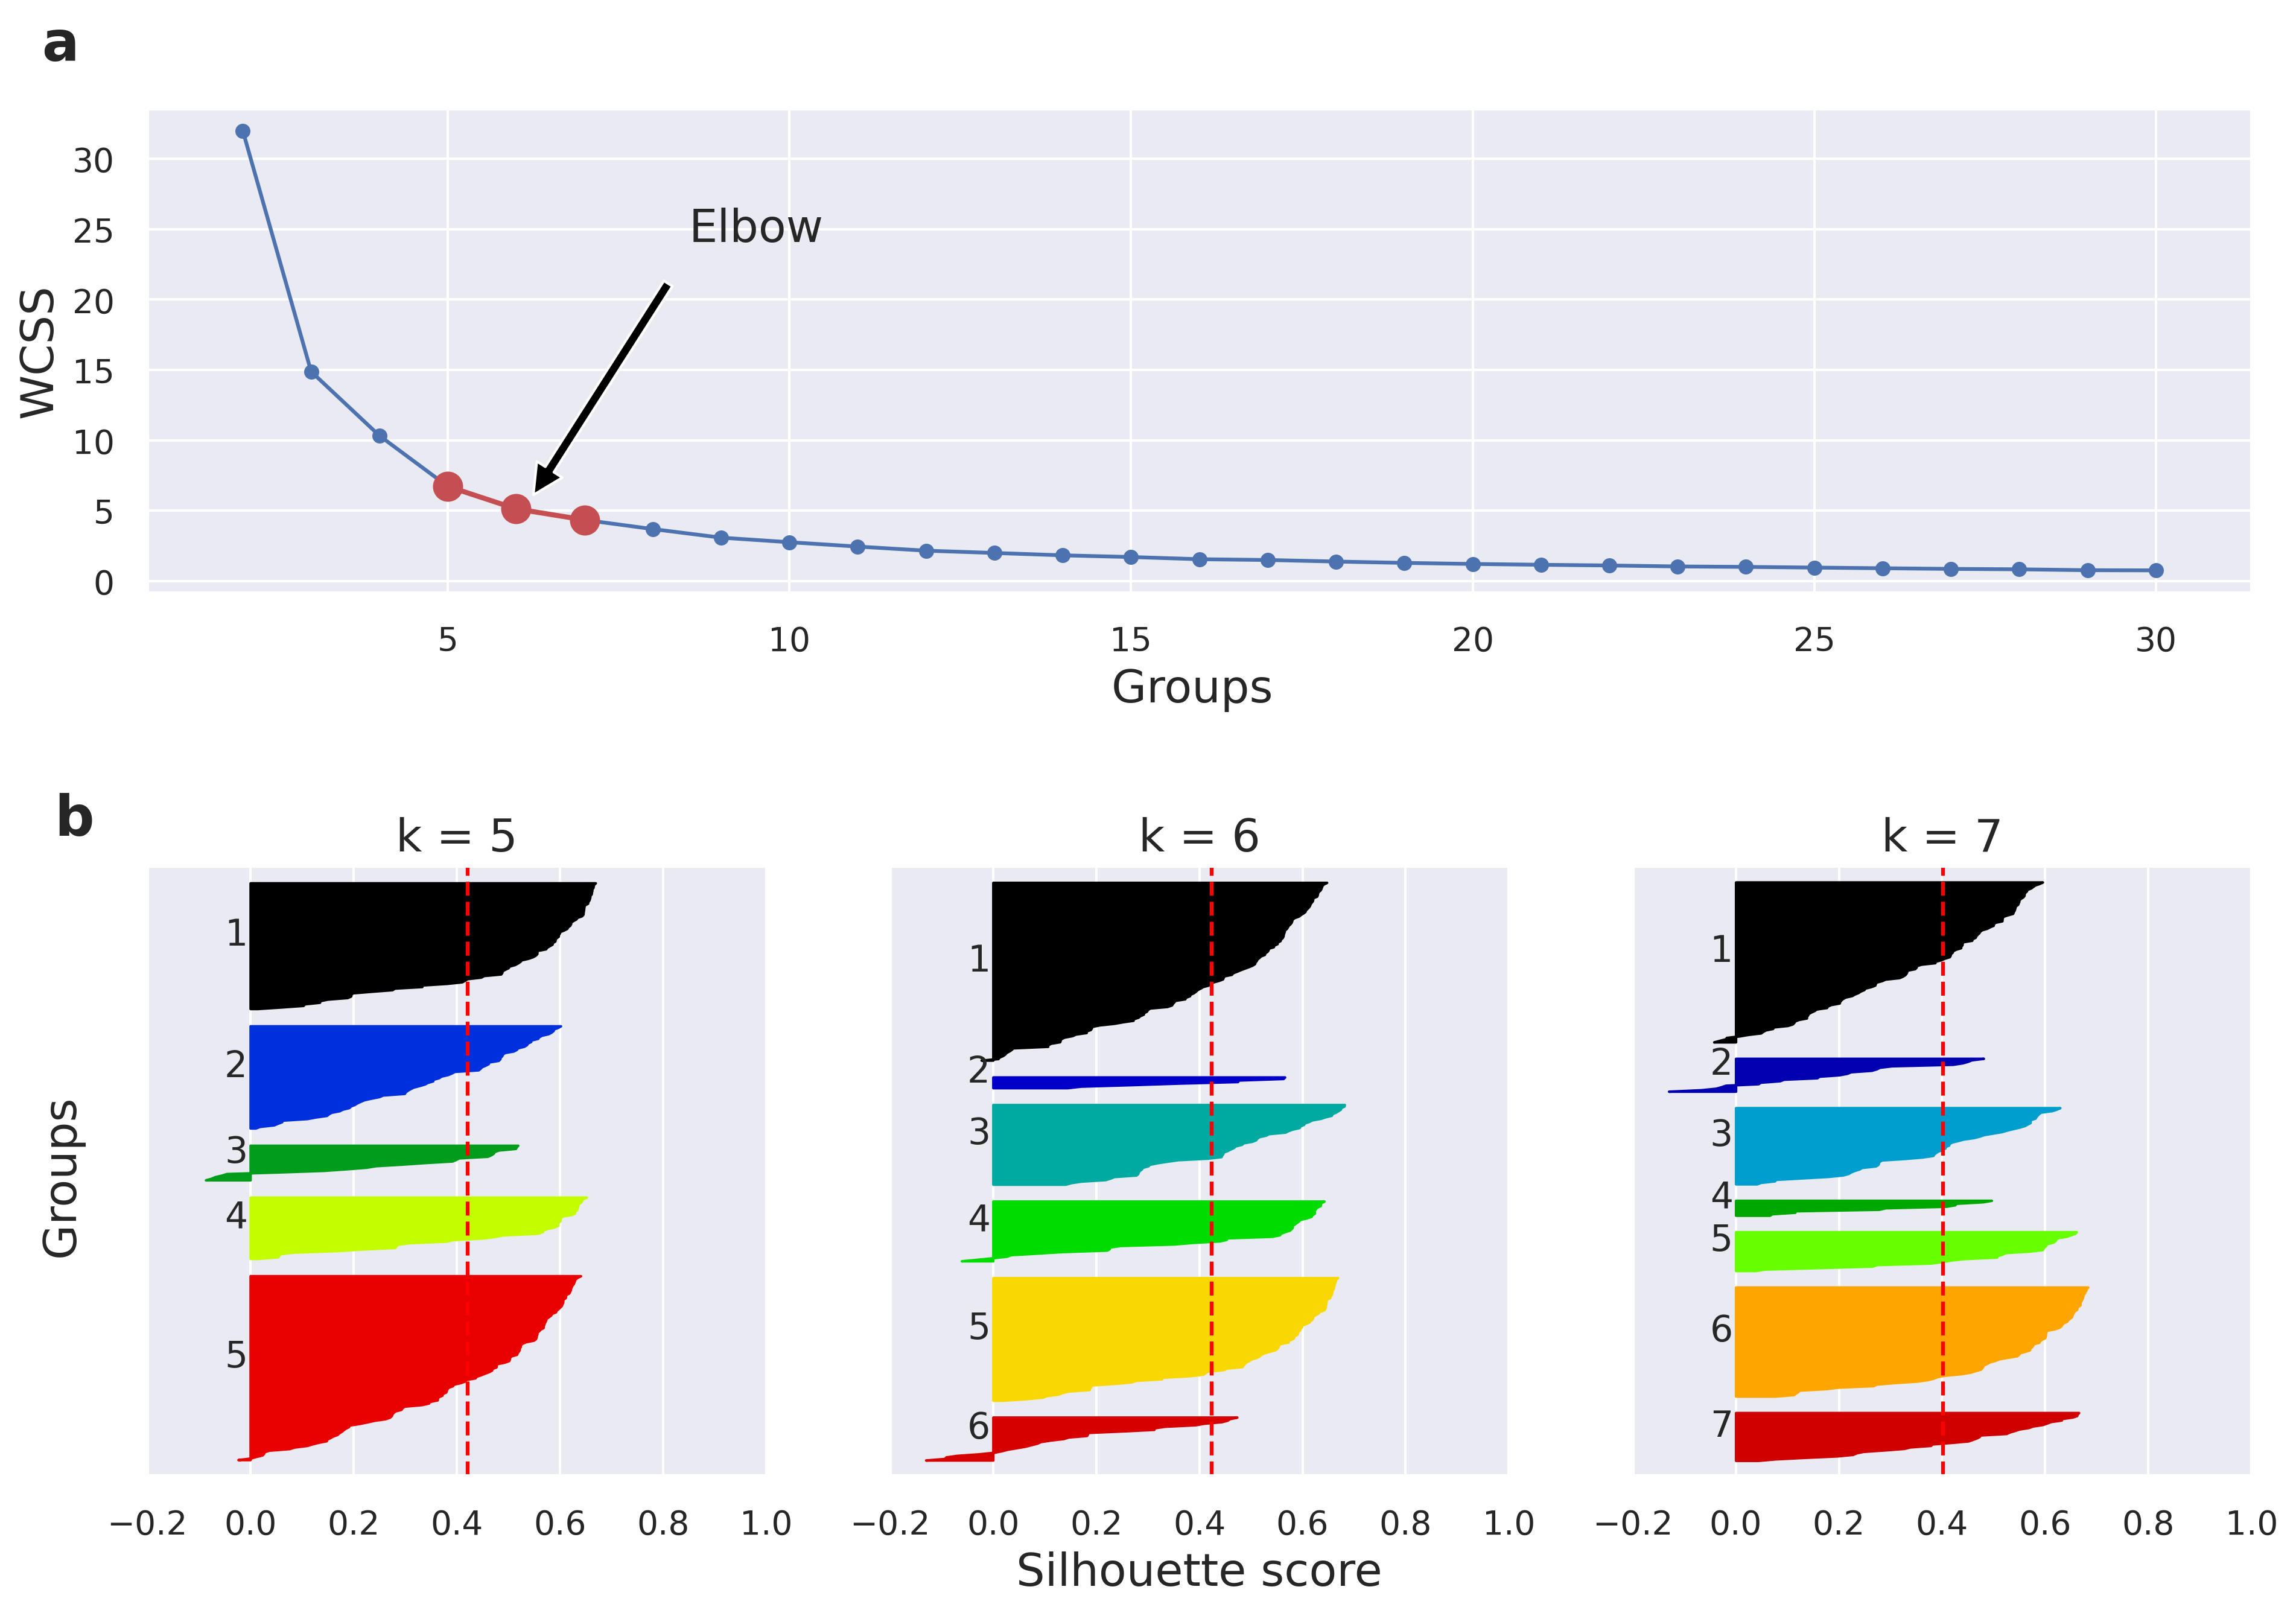

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [55]:
fontsize = 18
menork = 5 
maiork = 7
range_n = range(menork,maiork+1)
lim = 30
sns.set_theme()
sns.set(font_scale = 1.2)
silhouette_plot_(data_proces[features],range_n,lim)
data['group'] = model_top.predict(data_proces[features])


In [56]:
data.to_csv('/content/matopiba_emissions/output/matopiba_groups.csv')
data.group = data.group+1
lista = []
for g in data.group:
    lista.append(str("G"+str(g)))


data['group_name'] = lista
data.head()

## Groups presentation

In [99]:
l=range(1,max(data.group)+1)

count=0

grupos =[]

ps_all = []

parametric = True
for coluna in features:
    count+=1
    # print(coluna)
    k=0

    ps=[]
    met = []
    for i in l:
        k+=1
        for j in l[k:]:
            ''' Verificando se pode usar teste parametrico'''
            
            cat1 = data[data['group']==i]
            cat2 = data[data['group']==j]
            
            #Verificando o tamanho das amostras
            if min(len(cat1[coluna]),len(cat2[coluna]))>20:
                parametric = True
            else: parametric = False
            
            #verificando normalidade
            if parametric:
                _, p_1 = stats.normaltest(cat1[coluna])
                if p_1>=0.05:
                    # print(str('Normal ' + str(i)+ ' p ='), p_1)
                    parametric = True

                else: parametric = False
            
            if parametric:
                _, p_2 = stats.normaltest(cat2[coluna])
                if p_2>=0.05:
                    parametric = True
                else: parametric = False
            
            #Verificando Homocedasticidade
            if parametric:
                _, p_v = bartlett(cat1[coluna], cat2[coluna])
                if p_v>=0.05:
                    parametric = False
                
                
            # teste de diferenças
            if parametric:
                _,p=ttest_ind(cat1[coluna], cat2[coluna])
                if p<0.01:
                    met.append('t**')
                elif 0.01<p<0.05:
                    met.append('t*')
                else:
                    met.append('t')
                ps.append(p)
            else:
                _,p=mannwhitneyu(cat1[coluna], cat2[coluna])
                ps.append(p)
                if p<0.01:
                    met.append('U**')
                elif 0.01<p<0.05:
                    met.append('U*')
                else:
                    met.append('U')
                # print(str('Fail ' + str(i)+'_'+str(j)+' p ='))

     
            if count==1:
                grupos.append(str(str(i)+'_'+str(j)))
                
            
            
    if count==1:
        ps_all.append(grupos)
            
    ps_all.append(ps)
    ps_all.append(met)



In [100]:
ps_all = np.array(ps_all).transpose()
dif = pd.DataFrame(ps_all,columns=['Comparison',"'Agriculture and Livestock'",'Test',"LUC",'Test',"Energy",'Test','Waste','Test'])
dif.to_csv('/content/matopiba_emissions/output/statistic.csv')

dif.head(20)

,Comparison,'Agriculture and Livestock',Test,LUC,Test,Energy,Test,Waste,Test
0,1_2,4.4486549071262185e-05,U**,1.2042211933653515e-06,U**,1.2042211933653515e-06,U**,0.08272396698219048,U
1,1_3,1.2187045642232775e-25,U**,9.597575133628476e-25,U**,0.40691689764497685,U,0.49597388986879276,U
2,1_4,3.9554499608136606e-73,t**,2.1590634806295103e-21,U**,0.01472599711860026,U*,0.0006667543150694224,U**
3,1_5,1.0294108597528082e-29,U**,2.238017778652018e-30,U**,0.08382419938098168,U,0.031152663213252302,U*
4,1_6,0.1070548959981324,t,2.038015665782083e-43,t**,5.516325344568816e-16,U**,1.155373140024373e-09,U**
5,2_3,3.109692593182338e-06,U**,3.109692593182338e-06,U**,3.109692593182338e-06,U**,0.09442737824069253,U
6,2_4,5.1107338223515976e-06,U**,0.47243096518540373,U,5.1107338223515976e-06,U**,0.38572691460861613,U
7,2_5,0.1700667637623569,U,1.738611269331612e-06,U**,1.738611269331612e-06,U**,0.03591295060883048,U*
8,2_6,0.0002807278382098792,U**,0.0002807278382098792,U**,1.0164421882806045e-05,U**,0.22472705749215438,U
9,3_4,1.2739207333008779e-15,U**,1.3858760291311922e-16,U**,0.02284822761694854,U*,0.0034219945997669412,U**


MATOPIBA
Agriculture and Livestock    35.670178
LUC                          54.518145
Energy                        7.057391
Waste                         2.754286
dtype: float64

Group: 1
Agriculture and Livestock    31.074964
LUC                          62.714663
Energy                        3.997788
Waste                         2.212584
dtype: float64

Group: 2
Agriculture and Livestock    15.154200
LUC                          16.867263
Energy                       60.536933
Waste                         7.441603
dtype: float64

Group: 3
Agriculture and Livestock    50.454921
LUC                          44.231051
Energy                        3.286759
Waste                         2.027270
dtype: float64

Group: 4
Agriculture and Livestock    73.479459
LUC                          17.322032
Energy                        5.933140
Waste                         3.265370
dtype: float64

Group: 5
Agriculture and Livestock    16.818369
LUC                          78.470569
Energy  

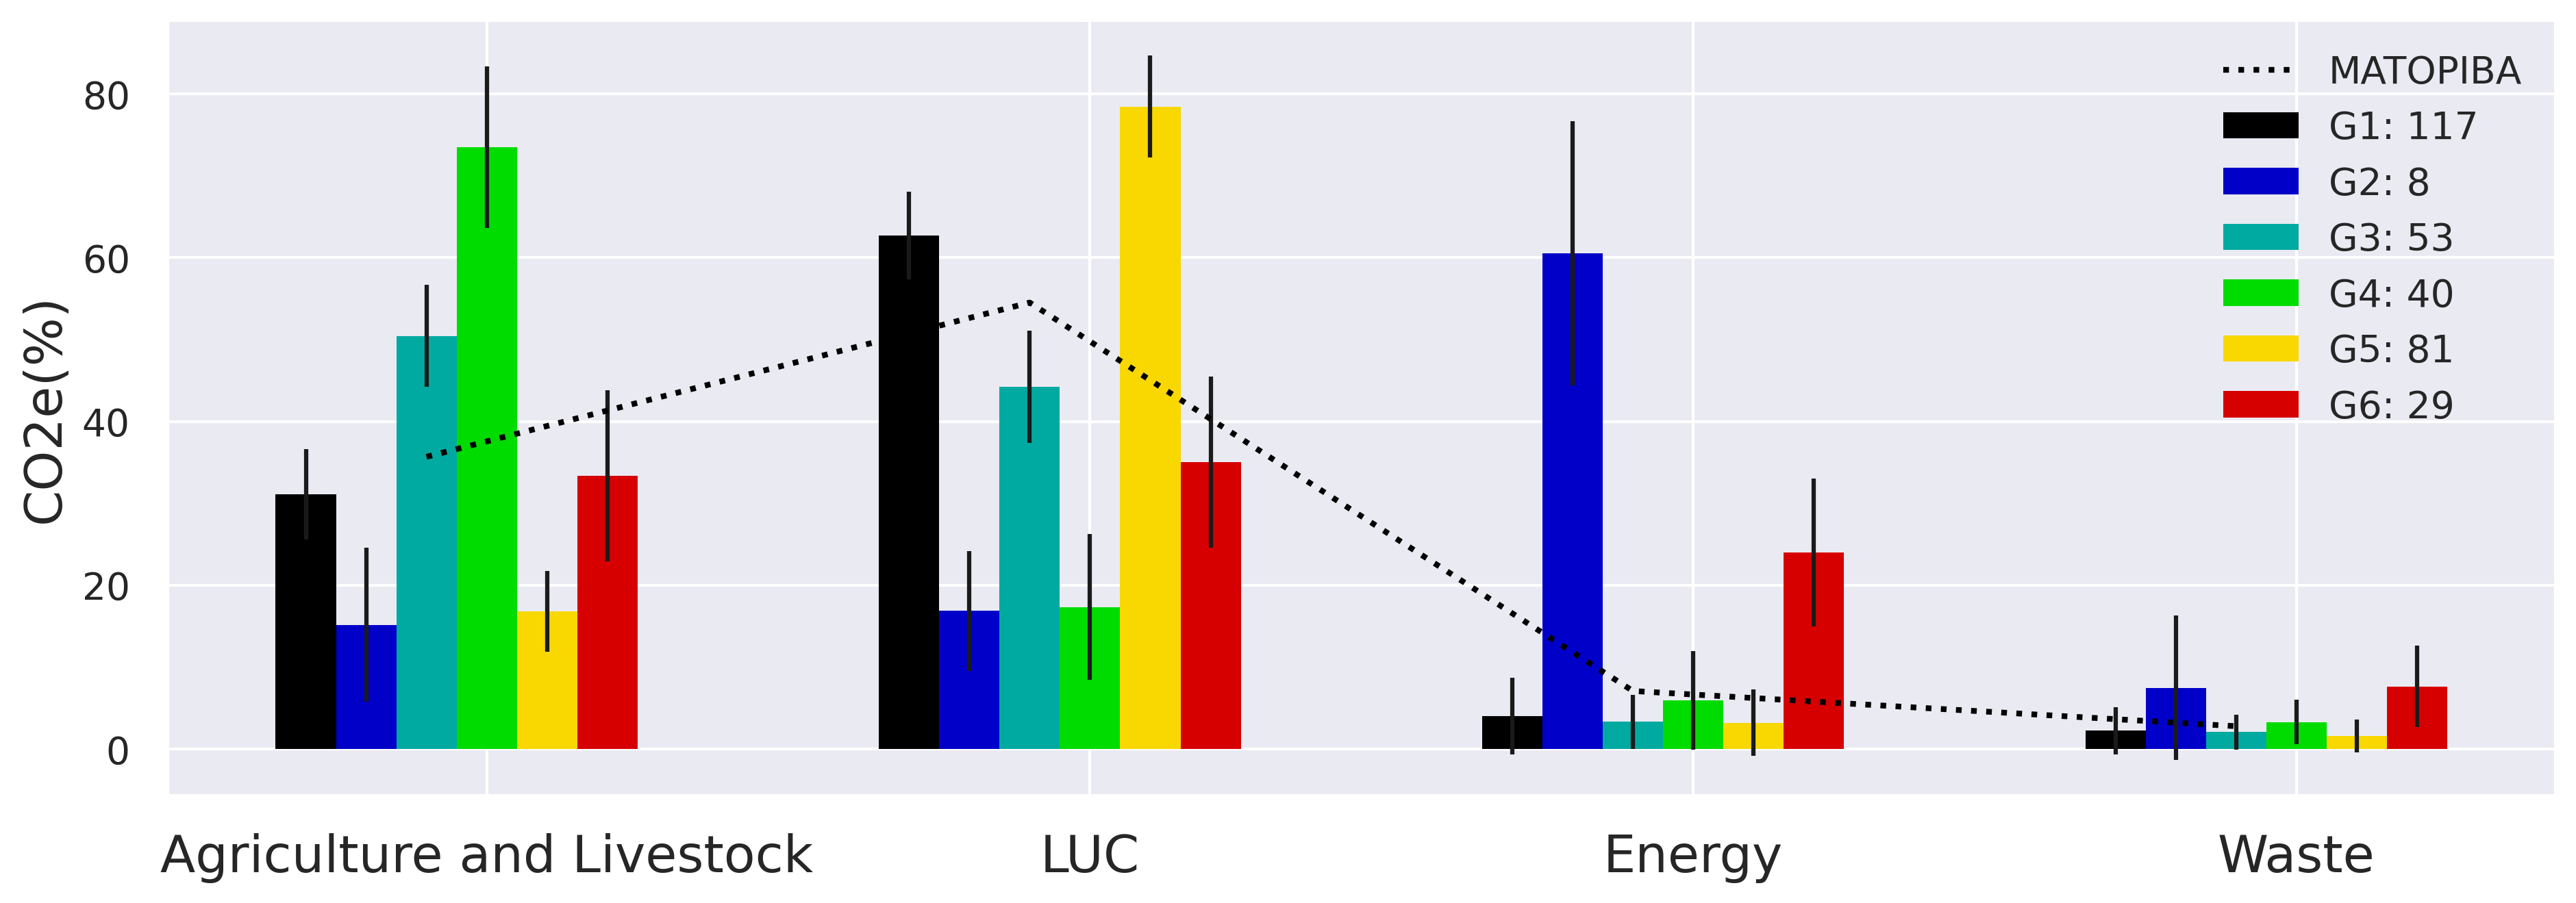

In [70]:
def bar_grupos(dados_sc,k):
  x = list(dados_sc.columns)[0:-1]
  
  fig = plt.figure(figsize = (15,5),dpi = 300)


  # plt.figure(figsize=(12, 5), dpi=300)
  j=0
  
  print("MATOPIBA")
  print(dados_sc.drop(['group'],axis=1).mean()*100)
  print()
    

  barWidth = 0.1
  r = np.arange(4)
  r = [x-3*barWidth for x in r]
  for i in range(1,k+1):
    dado_g = dados_sc.loc[dados_sc['group']==i]
    dado_g = dado_g.drop(['group'],axis=1)
    dado_g = dado_g
    color=(cm.nipy_spectral(float(i-1)*1.1 /k))
    r = [x + barWidth for x in r]
    plt.bar(r, dado_g.mean()*100, width = barWidth, color = color, 
            edgecolor = 'white', lw=0.0, alpha=1, yerr=dado_g.std()*100, label=str('G'+str(i)+': '+str(dado_g.shape[0])))
    
    print("Group: "+str(i))
    print(dado_g.mean()*100)
    print()
    j+=1

  #color=(cm.nipy_spectral(float(i+1) /k))
  dado_g = dados_sc.drop(['group'],axis=1)
  r = [x-3*barWidth for x in r]
  plt.grid(True)
  plt.plot(r,dado_g.mean()*100,':',label=('MATOPIBA'), 
        linewidth=2,color = 'black') # markersize=12*(dado_g.shape[0]/dados_sc.shape[0]))

  plt.xticks([r + barWidth for r in range(len(dado_g.mean()))],x,fontsize=fontsize)
  plt.ylabel('CO2e(%)',fontsize=fontsize)
  # plt.xlabel([ "Agropecuária","MUT","Energia","Resíduos"],fontsize=fontsize)
  plt.legend()
  '''
  # statistical annotation
  x1, x2 = 2, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
  y, h, col = tips['total_bill'].max() + 2, 2, 'k'
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
  plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
'''
    
    
bar_grupos(data[features_group],max(data[features_group].group))

plt.savefig("/content/matopiba_emissions/output/figure2b.pdf", format="pdf", dpi=1000)

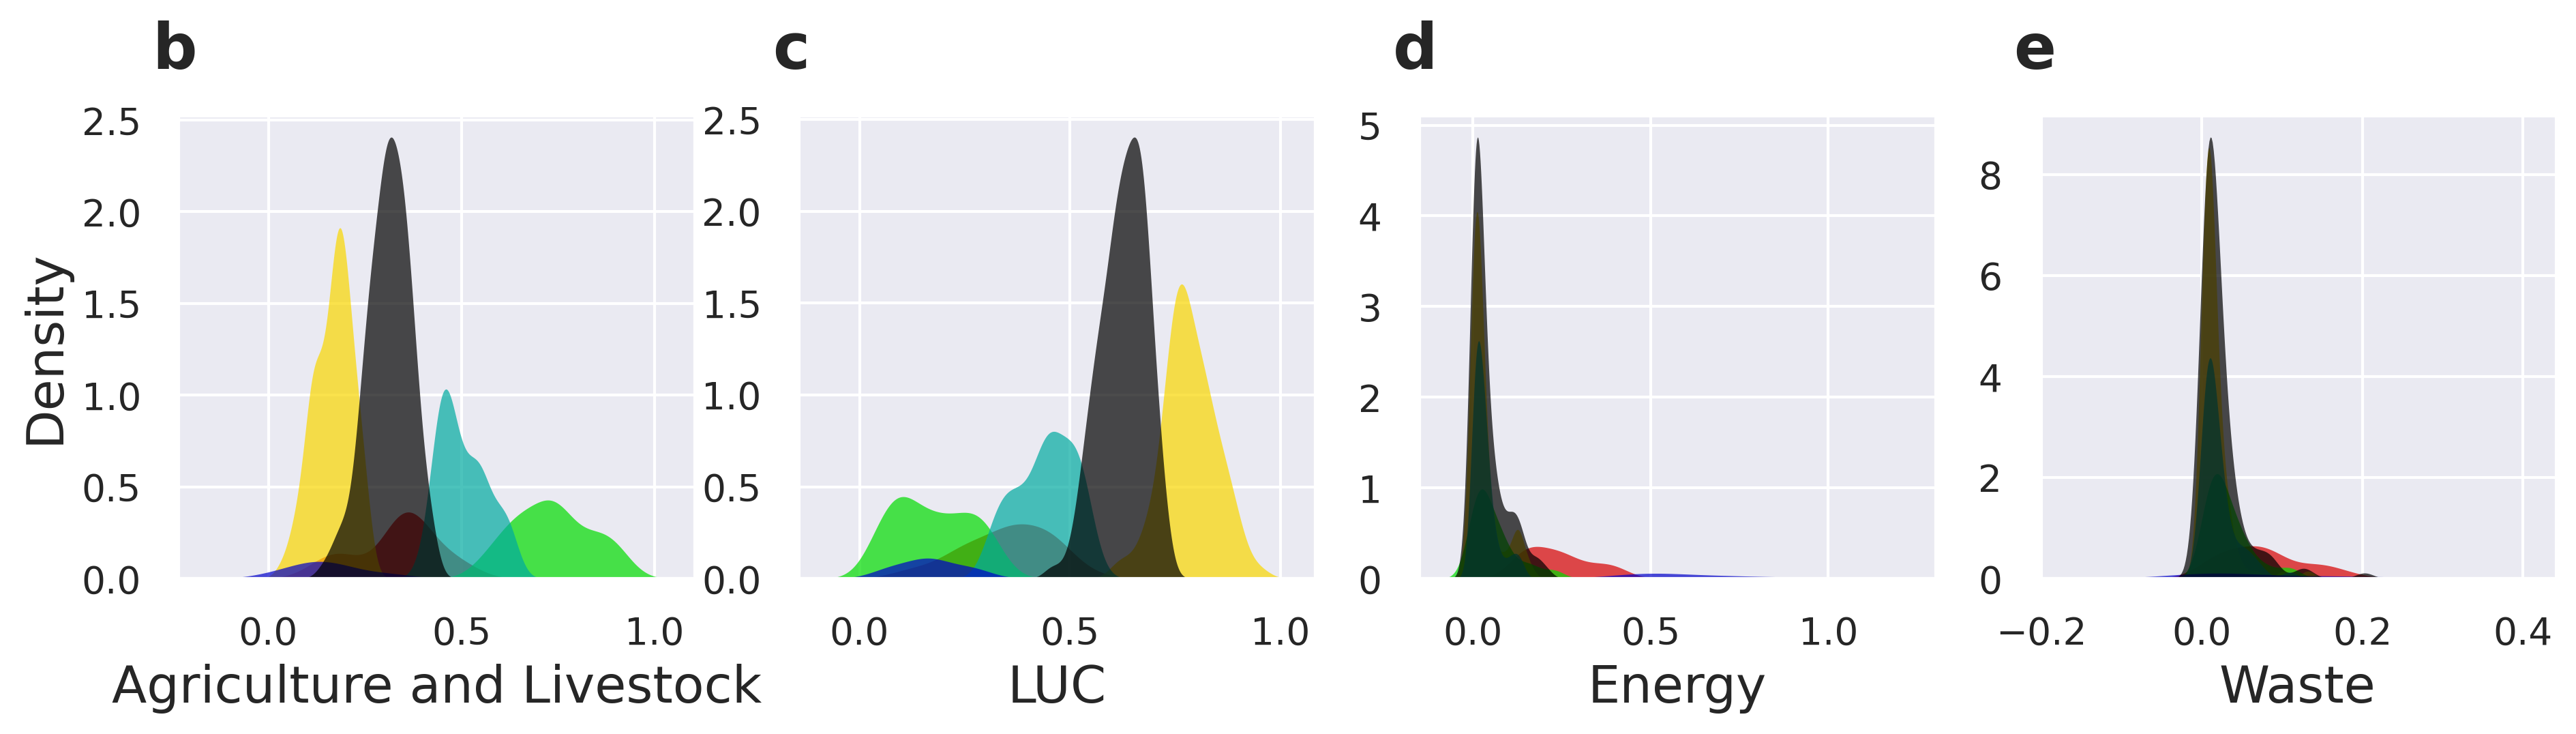

In [75]:
color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1/k))

fig = plt.figure(figsize = (15,3),dpi=300)

count=1
texto= ["b","c","d","e"]
for setor in features:

    plt.subplot(1,4,count)    
    ax=sns.kdeplot(data=data, x=setor, hue="group",palette=color ,fill=True,
   alpha=.7, linewidth=0,
)
    ax.text(-0.15/3, 1.1, texto[count-1], transform=ax.transAxes, 
            size=22, weight='bold')
    ax.set_xlabel(setor, fontsize=fontsize)
    if count ==1:
        ax.set_ylabel("Density", fontsize=fontsize)
        ax.legend_.set_title(None)
    else: 
        ax.set_ylabel(" ", fontsize=fontsize)
    count+=1
    ax.legend([],[], frameon=False)

plt.savefig("/content/matopiba_emissions/output/figure2a.pdf", format="pdf", dpi=1000)

##  Groups issuance profile

In [58]:
grupos = []
estados = ['MA','TO', 'PI','BA']
for i in range(1,7):
    linha =[]
    # print()
    grupo = data[data['group']==i]
    # print("Grupo "+str(i)+':')
    linha.append('G' +str(i))
    for est in estados:
        
        # print(est +"=" + str(len(grupo[grupo['ESTADOS'] == est]) ))
        linha.append(len(grupo[grupo['States'] == est]))
    grupos.append(linha)
tab2 = pd.DataFrame(grupos,columns=['Group','MA','TO','PI','BA'])
tab2.head(7)

,Group,MA,TO,PI,BA
0,G1,52,47,11,7
1,G2,3,4,0,1
2,G3,15,33,4,1
3,G4,5,18,4,13
4,G5,46,18,12,5
5,G6,13,12,1,3


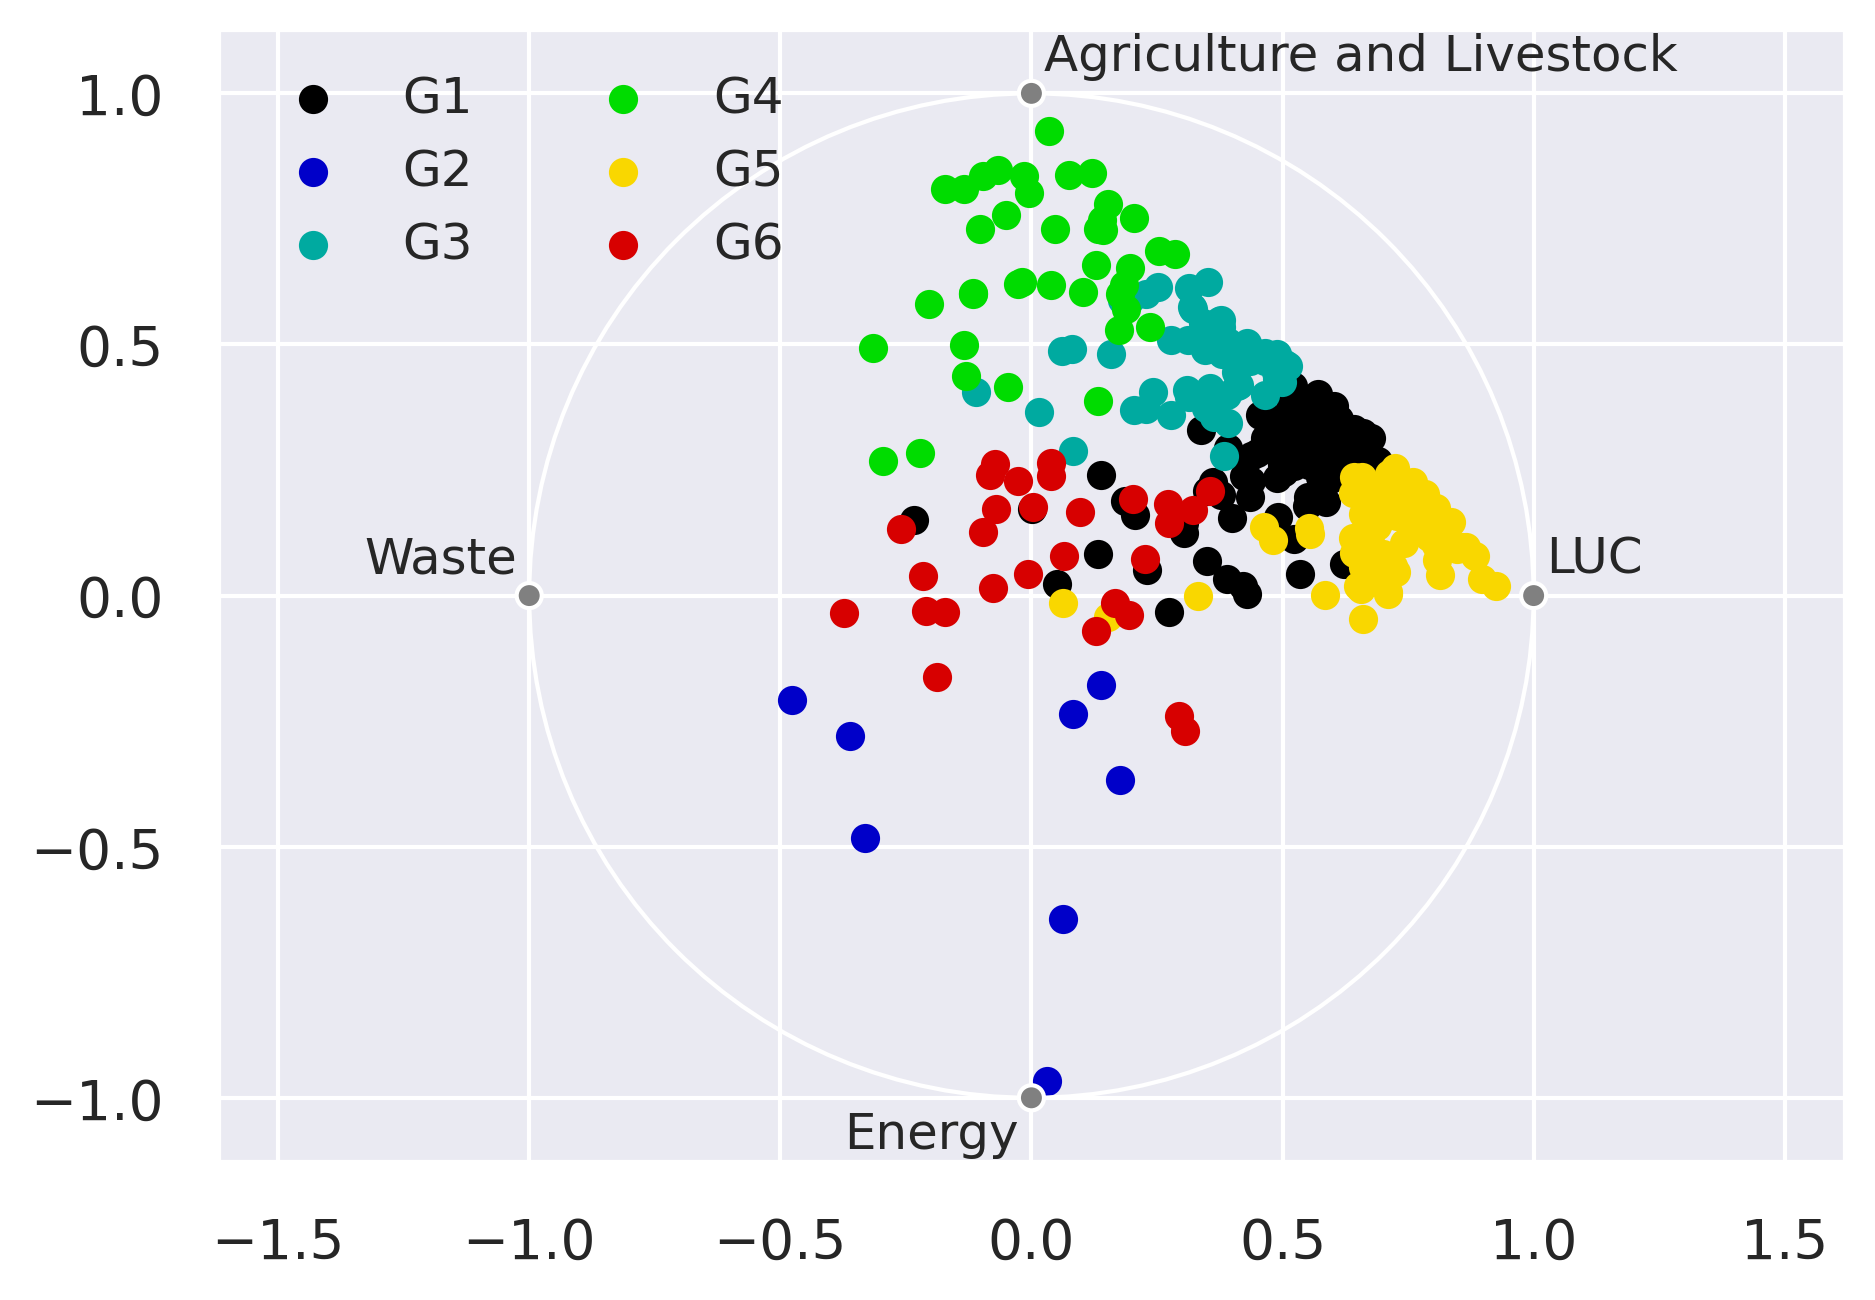

In [102]:
fig = plt.figure(figsize = (7,5),dpi = 300)

radviz(data[["LUC","Agriculture and Livestock","Waste","Energy","group_name"]].sort_values(by='group_name'), 'group_name',color = color)
plt.legend(loc='upper left', ncol=2,fontsize=12)
plt.savefig("/content/matopiba_emissions/output/figure3.pdf", format="pdf", dpi=1000)

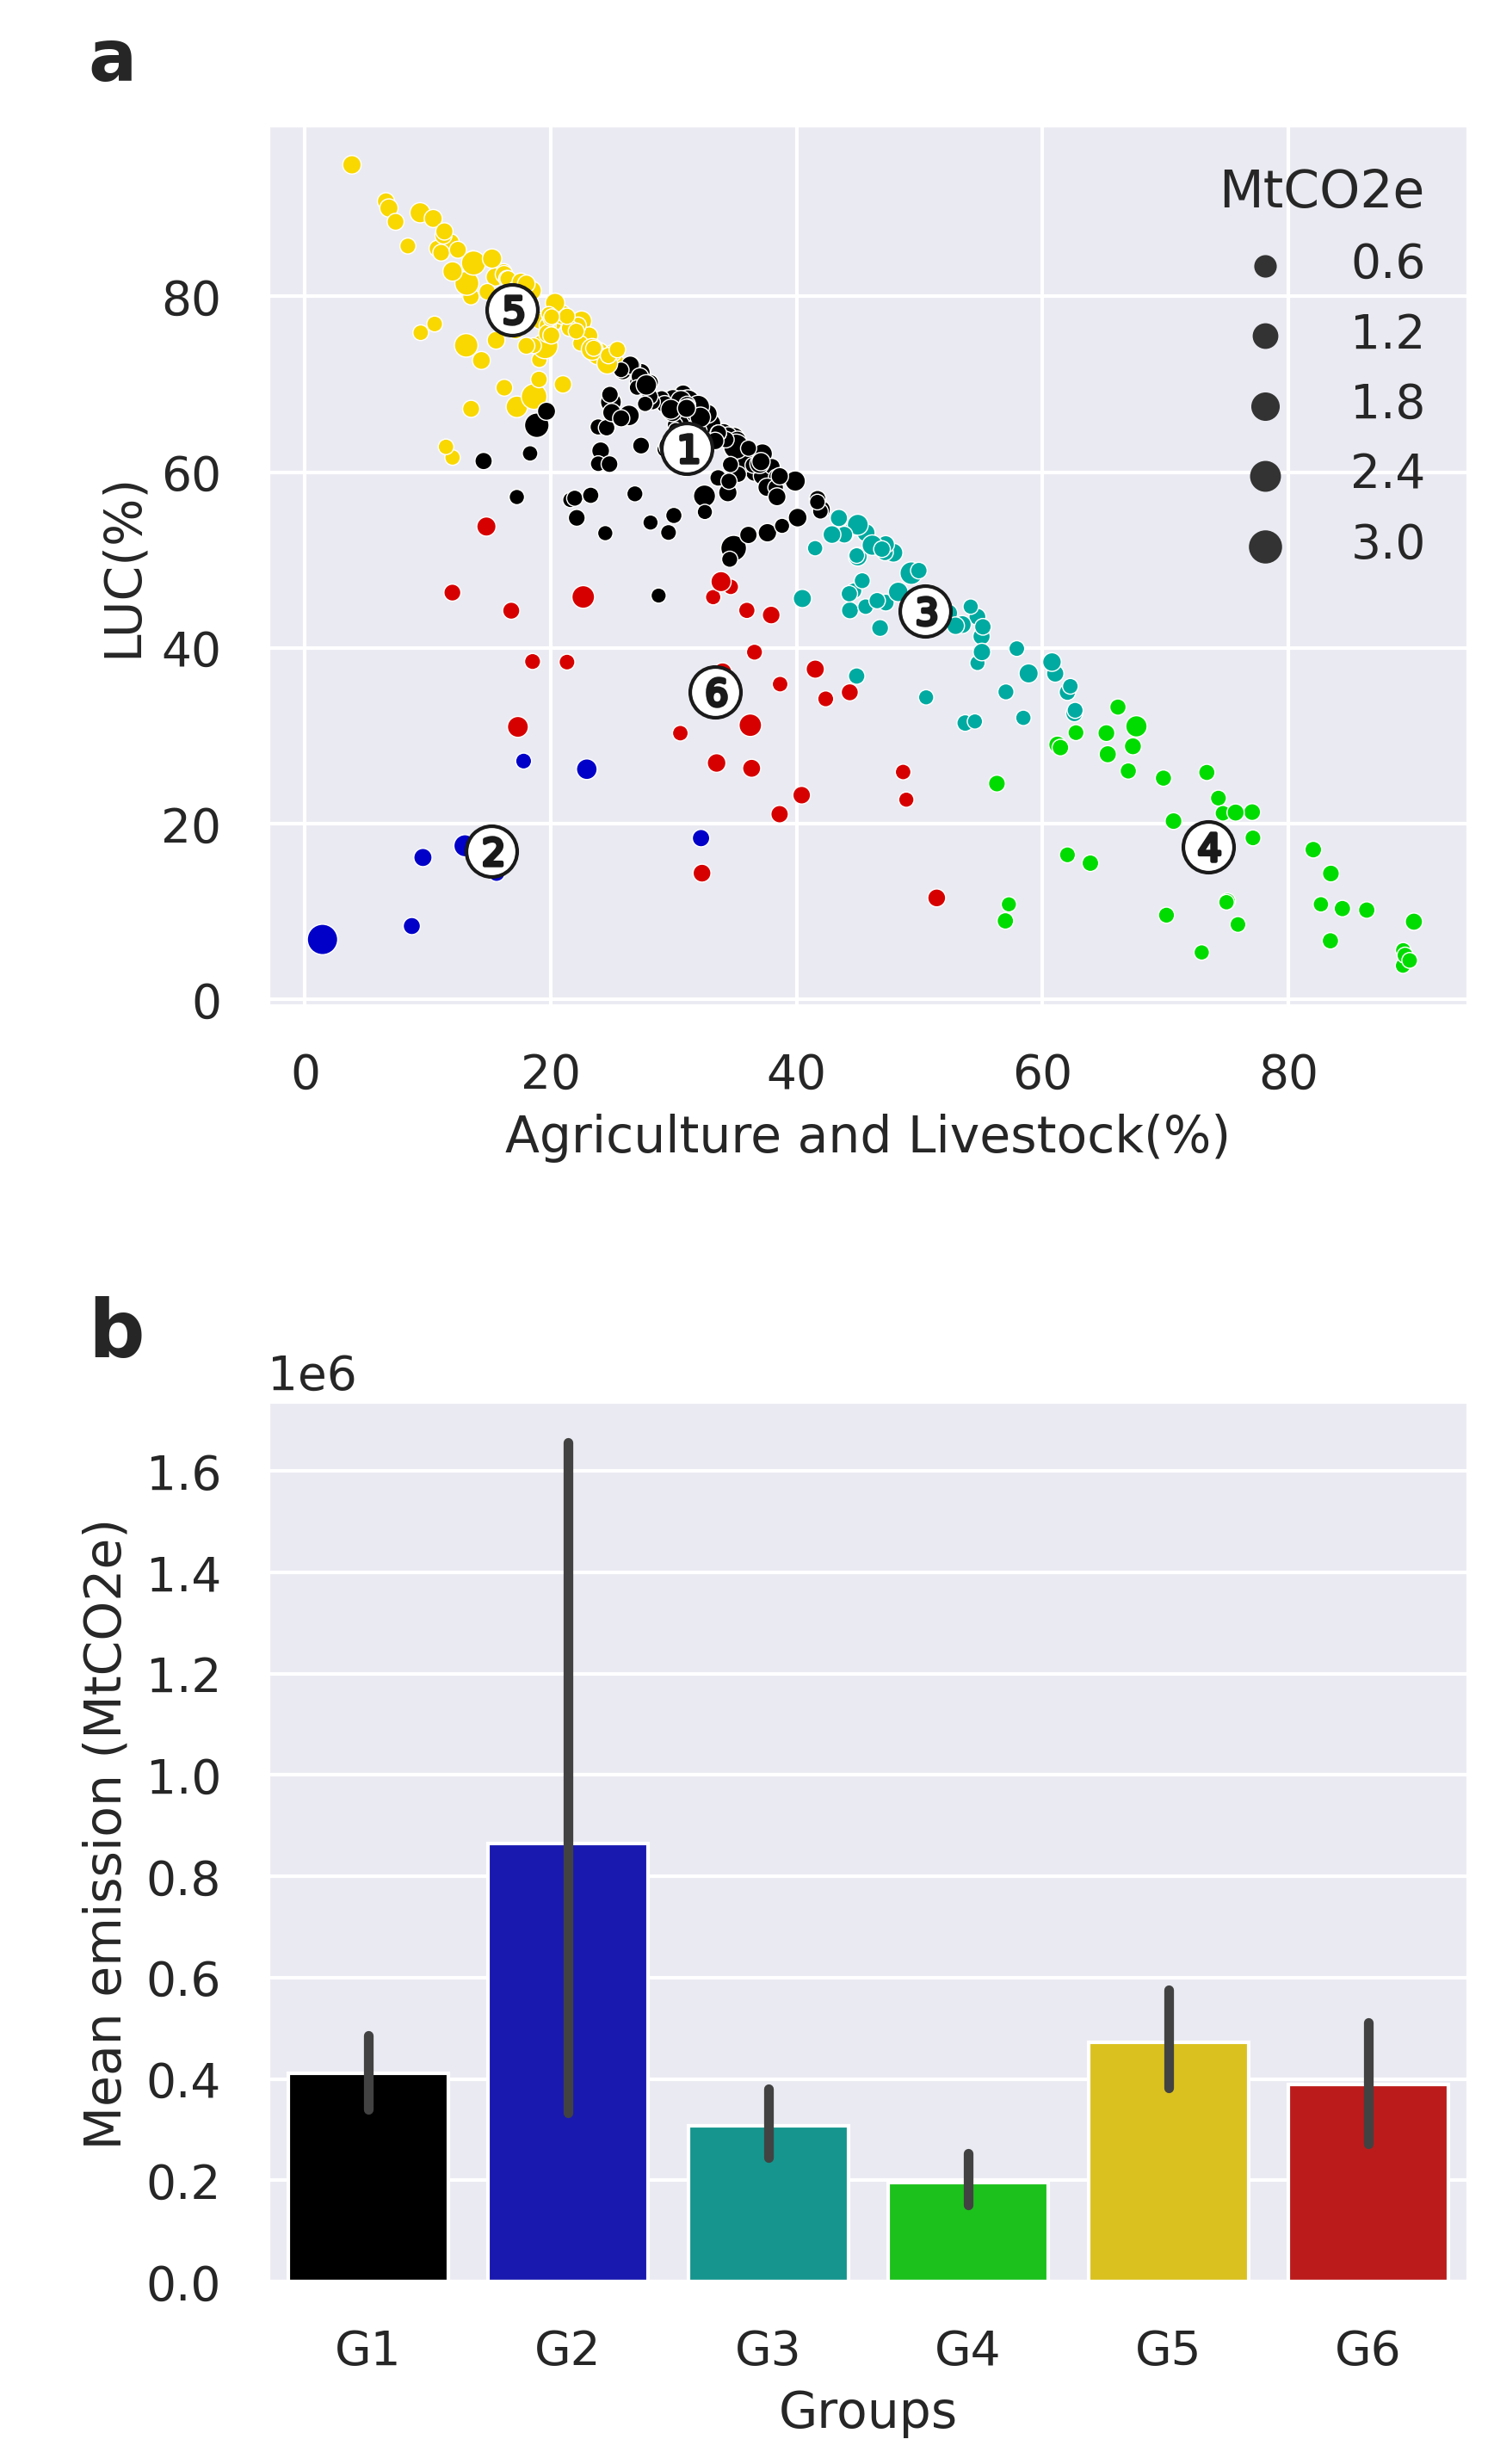

In [105]:
import matplotlib.gridspec as gridspec

fontsize=14
fig = plt.figure(figsize = (6,12),dpi = 300)
gs = gridspec.GridSpec(13, 1)

ax = fig.add_subplot(gs[0:5, 0])

n_clusters=k



color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1 /k))


ax=sns.scatterplot(data=data*100 , x="Agriculture and Livestock", y="LUC",  hue="group",legend = False,  alpha=1,
                   size ="emi_2018",s=5000, marker='o',  palette=color) 
ax=sns.scatterplot(data=data*100 , x="Agriculture and Livestock", y="LUC", size ="emi_2018",alpha=0.0,
           palette=color) 
ax.set_ylabel('LUC(%)',fontsize=fontsize)
ax.set_xlabel('Agriculture and Livestock(%)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'a', transform=ax.transAxes, 
    size=20, weight='bold')
plt.legend(title='MtCO2e')



centers = model_top.cluster_centers_ 

# Draw white circles at cluster centers
grupos_count = data.groupby('group').count()
group_size = list(grupos_count['Municipalities'])

for i, c in enumerate(centers):
  color=(cm.nipy_spectral(float(i-1)*1.1 /k))
  
  ax= plt.scatter(c[0]*100, c[1]*100, marker='o',
          c='white', alpha=1, s=200, edgecolor='k') #*group_size[i]
  ax=plt.scatter(c[0]*100, c[1]*100, marker='$%d$' % int(i+1), alpha=1,
              s=60, edgecolor='k',c='k')#color

    
color = []
for i in range(1,k+1):
    color.append(cm.nipy_spectral(float(i-1)*1.1 /k))


ax = fig.add_subplot(gs[7:12, 0])    

ax = sns.barplot(x='group_name', y="emi_2018",alpha=1,
                      data=data.sort_values(by=['group']),palette=color)
ax.set_xlabel('Groups',fontsize=fontsize)
ax.set_ylabel('\n Mean emission (MtCO2e)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
    size=22, weight='bold')




plt.savefig("/content/matopiba_emissions/output/figure4.pdf", format="pdf", dpi=1000)

### Testing for the presence of correlations

In [107]:
_, p1 = stats.normaltest(data['Agriculture and Livestock'])
_, p2 = stats.normaltest(data['LUC'])
print("Normality test: ",p1,p2)
data[["Agriculture and Livestock", 'LUC']].corr()
## -0.783561

Normality test:  1.8695449038763153e-08 8.360050436410542e-06


,Agriculture and Livestock,LUC
Agriculture and Livestock,1.000000,-0.783561
LUC,-0.783561,1.000000


In [109]:
#excluindo o grupo 2
_, p1 = stats.normaltest(data['Agriculture and Livestock'][data.group !=2])
_, p2 = stats.normaltest(data['LUC'][data.group !=2])
print("Normality test: ",p1,p2)
data[["Agriculture and Livestock", 'LUC']][data.group !=2].corr()
## -0.882981

Normality test:  2.6981531863338655e-08 2.553853543496754e-05


,Agriculture and Livestock,LUC
Agriculture and Livestock,1.000000,-0.882981
LUC,-0.882981,1.000000


In [111]:
#excluindo o grupo 2 
_, p1 = stats.normaltest(data['Agriculture and Livestock'][data.group !=2][data.group !=6])
_, p2 = stats.normaltest(data['LUC'][data.group !=2][data.group !=6])
print("Normality test: ",p1,p2)
data[["Agriculture and Livestock", 'LUC']][data.group !=2][data.group !=6].corr()
## -0.954353

Normality test:  3.967594364228804e-07 6.673344850383395e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Agriculture and Livestock,LUC
Agriculture and Livestock,1.000000,-0.954353
LUC,-0.954353,1.000000


In [114]:
data[data.group==5].sort_values(by='emi_2018',ascending=False).head(5)

,States,Municipalities,emi_2018,emi_agri_2018,emi_luc_2018,emi_energy_2018,emi_waste_2018,pib_2018,population,Agriculture and Livestock,LUC,Energy,Waste,group,group_name
94,BA,Correntina,1991731.82,371215.01,1366565,244717.75,9234.07,1944161.68,32081,0.186378,0.686119,0.122867,0.004636,5,G5
137,MA,GrajaÃº,1978841.30,386536.69,1471716,101171.49,19417.13,751654.33,68876,0.195335,0.743726,0.051127,0.009812,5,G5
150,MA,Itinga do MaranhÃ£o,1660611.20,227694.68,1391740,29303.10,11873.41,321167.19,25931,0.137115,0.838089,0.017646,0.007150,5,G5
83,MA,CodÃ³,1616341.21,212846.61,1317333,47292.27,38869.33,963180.19,122597,0.131684,0.815009,0.029259,0.024048,5,G5
40,MA,Barra do Corda,1595140.78,272482.87,1228381,67637.99,26638.92,723386.24,87793,0.170821,0.770077,0.042403,0.016700,5,G5
